In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random

from progress.bar import Bar
import statsmodels
from statsmodels.graphics.tsaplots import plot_acf

import collections
import numpy.fft as fft
import collections
from scipy.signal import find_peaks, spectrogram, stft
from scipy.fft import fftshift
from matplotlib.colors import LogNorm

# Spectrogram

In [2]:
def simulation_Q(Q):
    
    '''
    Fonction permettant d'automatiser la simulation en ne changeant que le paramètre Q
    '''
    
    nCell = 100
    ##constantes
    n = 2
    alpha = 111
    kappa = 20
    k_s0 = 1
    k_s1 = 0.01
    t = 4500 
    eta = 2.0

    D = 2

    beta = []
    for i in range(nCell):
        beta.append(random.gauss(1,0.05))
    tau = 0.04 ##a voir

    ##initialisation des matrices
    a = np.zeros((nCell, t))
    bQ1 = np.zeros((nCell, t))
    c = np.zeros((nCell, t))

    A = np.zeros((nCell, t))
    B = np.zeros((nCell, t))
    C = np.zeros((nCell, t))

    S = np.zeros((nCell, t))
    Se = np.zeros((nCell, t))
    
    # Initialisation aléatoire pour plus de variabilité

    a[:,0] = random.randint(1,50)
    bQ1[:,0] = random.randint(1,50)
    c[:,0] = random.randint(1,50)

    A[:,0] = random.randint(1,50)
    B[:,0] = random.randint(1,50)
    C[:,0] = random.randint(1,50)

    S[:,0] = random.randint(1,50)
    Se[:,0] = random.randint(1,50)

    time = np.arange(0,t)

    for j in range(0, t-1):
        for i in range(0, nCell):
            xi = random.gauss(0, D)
            betabis = beta[i] + (xi*tau)

            Se[i, j] = Q * np.mean(S[:, j])

            abis = a[i, j] + tau / 2 * (-a[i, j] + (alpha / (1 + C[i, j] ** n)))
            bbis = bQ1[i, j] + tau / 2 * (-bQ1[i, j] + (alpha / (1 + A[i, j] ** n)))
            cbis = c[i, j] + tau / 2 * (-c[i, j] + (alpha / (1 + B[i, j] ** n)) + (kappa * S[i, j] / 1 + S[i, j]))

            Abis = A[i, j] + tau / 2 * (betabis * (a[i, j] - A[i, j]))
            Bbis = B[i, j] + tau / 2 * (betabis * (bQ1[i, j] - B[i, j]))
            Cbis = C[i, j] + tau / 2 * (betabis * (c[i, j] - C[i, j]))

            Sbis = S[i, j] + tau / 2 * ((-k_s0 * S[i, j]) + (k_s1 * A[i, j]) - (eta * (S[i, j] - Se[i, j])))

            a[i, j + 1] = a[i, j] + tau * (-abis + (alpha / (1 + Cbis ** n)))
            bQ1[i, j + 1] = bQ1[i, j] + tau * (-bbis + (alpha / (1 + Abis ** n)))
            c[i, j + 1] = c[i, j] + tau * (-cbis + (alpha / (1 + Bbis ** n)) + (kappa * Sbis / 1 + Sbis))

            A[i, j + 1] = A[i, j] + tau * (betabis * (abis - Abis))
            B[i, j + 1] = B[i, j] + tau * (betabis * (bbis - Bbis))
            C[i, j + 1] = C[i, j] + tau * (betabis * (cbis - Cbis))

            S[i, j + 1] = S[i, j] + tau * ((-k_s0 * Sbis) + (k_s1 * Abis) - (eta * (Sbis - Se[i, j])))
            
    fourierlist = []

    for cell in range(nCell):
        #Centralisation et normalisation de b
        b1Q1norm = (bQ1[cell, :] - (max(bQ1[cell, :])/2))/(max(bQ1[cell, :])/2)

        #Autocorrelation des valeurs : calcul la somme des multiplications des valeurs aux temps avec un décallage (b(t) * b(t+i))
        autocorrelQ1 = np.correlate(b1Q1norm, b1Q1norm, mode="full")
        autocorrelQ1 = autocorrelQ1[len(autocorrelQ1)//2:]

        #soustraction de la moyenne des valeurs à toutes les valeurs :
        averageautocorr = sum(autocorrelQ1)/len(autocorrelQ1)
        autocorrelQ1 = autocorrelQ1 - averageautocorr

        #Réalisation des transformées de fourier et récupération dans une liste
        fourierlist.append(np.fft.fft(autocorrelQ1))

    #calcul des fréquences fft
    freqfour = np.fft.fftfreq(len(autocorrelQ1),d=tau)

    #calcul de la moyenne des fft:
    fourier = np.array([np.mean(k) for k in zip(*fourierlist)])

    return fourier, freqfour

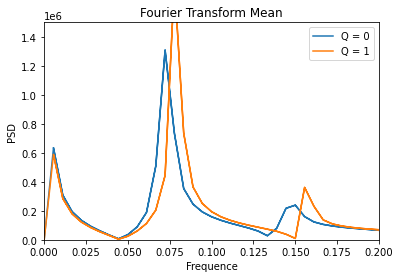

In [3]:
#Plot de la transfo de fourier
fourierQ0, freqfourQ0 = simulation_Q(0)
fourierQ1, freqfourQ1 = simulation_Q(1)
plt.plot(abs(freqfourQ0), abs(fourierQ0), label = "Q = 0")
plt.plot(abs(freqfourQ1), abs(fourierQ1), label = "Q = 1")
plt.ylim(0, 1500000)
plt.xlabel('Frequence')
plt.ylabel('PSD')
plt.title("Fourier Transform Mean")
plt.legend()
plt.xlim(0,0.2)
plt.show()

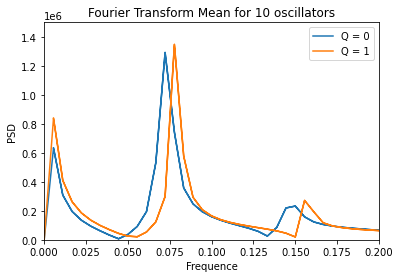

In [6]:
freq_four0_sum = 0
freq_four1_sum = 0

four0_sum = 0
four1_sum = 0

list_freq_four0 = []
list_freq_four1 = []

nbr_oscillator = 10

for i in range(1,nbr_oscillator + 1):

    fourierQ0, freqfourQ0 = simulation_Q(0)
    fourierQ1, freqfourQ1 = simulation_Q(1)
    
    list_freq_four0.append(freqfourQ0)
    list_freq_four1.append(freqfourQ1)

    freq_four0_sum += abs(freqfourQ0)
    freq_four1_sum += abs(freqfourQ1)

    mean_freq_four0 = freq_four0_sum / i
    mean_freq_four1 = freq_four1_sum / i

    four0_sum += abs(fourierQ0)
    four1_sum += abs(fourierQ1)

    mean_four0 = four0_sum / i
    mean_four1 = four1_sum / i
        
    if i == nbr_oscillator:
        plt.plot(mean_freq_four0, mean_four0, label = "Q = 0")
        plt.plot(mean_freq_four1, mean_four1, label = "Q = 1")
        plt.ylim(0, 1500000)
        plt.xlabel('Frequence')
        plt.ylabel('PSD')
        plt.title("Fourier Transform Mean for 10 oscillators")
        plt.legend()
        plt.xlim(0,0.2)
        plt.show()
        
        #plt.subplot(2,1)
        #plt.specgram(list_freq_four0)
        #plt.xlabel('oscillator')
        #plt.colorbar()
        #plt.yscale('log')

[array([4.42236114e-11     +0.j        , 1.70501326e+03-278716.05312066j,
       1.84118380e+03-129912.17737529j, ...,
       2.15157380e+03 +75043.40261178j, 1.84118380e+03+129912.17737529j,
       1.70501326e+03+278716.05312066j]), array([-3.49538141e-10     +0.j        ,  3.37754838e+03-280339.34910106j,
        3.48084849e+03-133243.65190982j, ...,
        3.66784621e+03 +80012.51686681j,  3.48084849e+03+133243.65190982j,
        3.37754838e+03+280339.34910106j])]


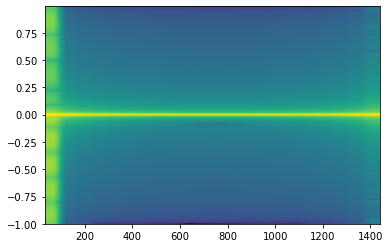

In [19]:
list_four0 = []

for i in range(1,3):
    list_four0.append(simulation_Q(0))
    plt.specgram(simulation_Q(0))

print(list_four0)

/home/kevin/.local/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: Only one segment is calculated since parameter NFFT (=256) >= signal length (=29).
  """Entry point for launching an IPython kernel.


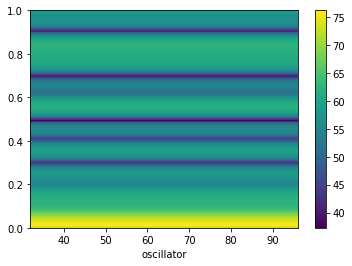

In [20]:
plt.specgram(list_four0, sides='onesided')
plt.xlabel('oscillator')
plt.colorbar()
#plt.yscale('log')

In [21]:
list_four1 = []

for i in range(1,5):
    list_four1.append(simulation_Q(0))
    #plt.specgram(simulation_Q(0))

/home/kevin/.local/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: Only one segment is calculated since parameter NFFT (=256) >= signal length (=29).
  """Entry point for launching an IPython kernel.


Text(0.5, 0, 'oscillator')

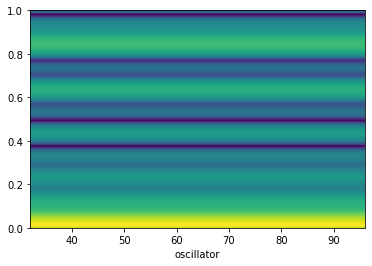

In [24]:
plt.specgram(list_four1, sides='onesided')
plt.xlabel('oscillator')
#plt.yscale('log')